In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta


## Wczytanie katalogu zdarzeń sejsmicznych
Najpierw wczytamy plik katalogu, który zawiera informacje o zdarzeniach sejsmicznych zarejestrowanych na Księżycu.

In [5]:
catalog_path = '../data/lunar/training/catalogs/apollo12_catalog_GradeA_final.csv'
catalog = pd.read_csv(catalog_path, parse_dates=['time_abs(%Y-%m-%dT%H:%M:%S.%f)'])
# Wyświetlenie pierwszych kilku wierszy
catalog.head()


,filename,time_abs(%Y-%m-%dT%H:%M:%S.%f),time_rel(sec),evid,mq_type
0,xa.s12.00.mhz.1970-01-19HR00_evid00002,1970-01-19 20:25:00,73500.0,evid00002,impact_mq
1,xa.s12.00.mhz.1970-03-25HR00_evid00003,1970-03-25 03:32:00,12720.0,evid00003,impact_mq
2,xa.s12.00.mhz.1970-03-26HR00_evid00004,1970-03-26 20:17:00,73020.0,evid00004,impact_mq
3,xa.s12.00.mhz.1970-04-25HR00_evid00006,1970-04-25 01:14:00,4440.0,evid00006,impact_mq
4,xa.s12.00.mhz.1970-04-26HR00_evid00007,1970-04-26 14:29:00,52140.0,evid00007,deep_mq


<div class="alert alert-block alert-info"> <b>NOTE:</b> Katalog zawiera informacje o plikach z danymi sejsmicznymi, absolutny czas rozpoczęcia pomiaru <code>time_abs(%Y-%m-%dT%H:%M:%S.%f)</code>, relatywny czas wystąpienia trzęsienia <code>time_rel(sec)</code> oraz unikalny identyfikator zdarzenia <code>evid</code>. </div>

## Wstępna analiza katalogu
Liczba zdarzeń w katalogu python

In [6]:
print(f"Liczba zdarzeń w katalogu: {len(catalog)}")

Liczba zdarzeń w katalogu: 76


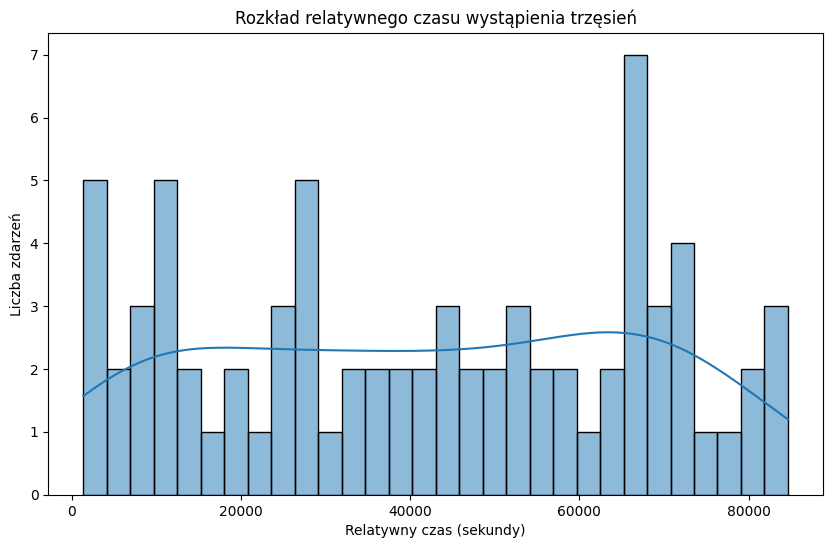

In [20]:
plt.figure(figsize=(10, 6))
sns.histplot(catalog['time_rel(sec)'], bins=30, kde=True)
plt.title('Rozkład relatywnego czasu wystąpienia trzęsień')
plt.xlabel('Relatywny czas (sekundy)')
plt.ylabel('Liczba zdarzeń')
plt.show()

## Wczytanie danych sejsmicznych dla wybranego zdarzenia

Wybierzemy jedno zdarzenie z katalogu i wczytamy odpowiadający mu plik z danymi sejsmicznymi.

In [21]:
# Wybór pierwszego zdarzenia
event = catalog.iloc[1]  # Możesz zmienić indeks, aby wybrać inne zdarzenie

filename = event['filename']
evid = event['evid']
quake_time_rel = event['time_rel(sec)']  # Relatywny czas wystąpienia trzęsienia

print(f"Analiza zdarzenia: {evid}")
print(f"Nazwa pliku: {filename}")
print(f"Czas wystąpienia trzęsienia (relatywny): {quake_time_rel} sekund od początku pomiaru")


Analiza zdarzenia: evid00003
Nazwa pliku: xa.s12.00.mhz.1970-03-25HR00_evid00003
Czas wystąpienia trzęsienia (relatywny): 12720.0 sekund od początku pomiaru


In [22]:
# Ścieżka do pliku z danymi sejsmicznymi
data_file_path = f"../data/lunar/training/data/S12_GradeA/{filename}.csv"

# Wczytanie danych
seismic_data = pd.read_csv(data_file_path)

# Wyświetlenie pierwszych kilku wierszy
seismic_data.head()


,time_abs(%Y-%m-%dT%H:%M:%S.%f),time_rel(sec),velocity(m/s)
0,1970-03-25T00:00:00.440000,0.000000,-5.481780e-15
1,1970-03-25T00:00:00.590943,0.150943,-6.878653e-15
2,1970-03-25T00:00:00.741887,0.301887,-7.486137e-15
3,1970-03-25T00:00:00.892830,0.452830,-7.191481e-15
4,1970-03-25T00:00:01.043774,0.603774,-6.287278e-15


<div class="alert alert-block alert-info"> <b>NOTE:</b> Dane sejsmiczne zawierają czas absolutny pomiaru (<code>time_abs(%Y-%m-%dT%H:%M:%S.%f)</code>), relatywny czas od początku pomiaru (<code>time_rel(sec)</code>) oraz wartość prędkości (<code>velocity(m/s)</code>) w m/s. </div>

# Wizualizacja sygnału sejsmicznego

Wykres sygnału w czasie

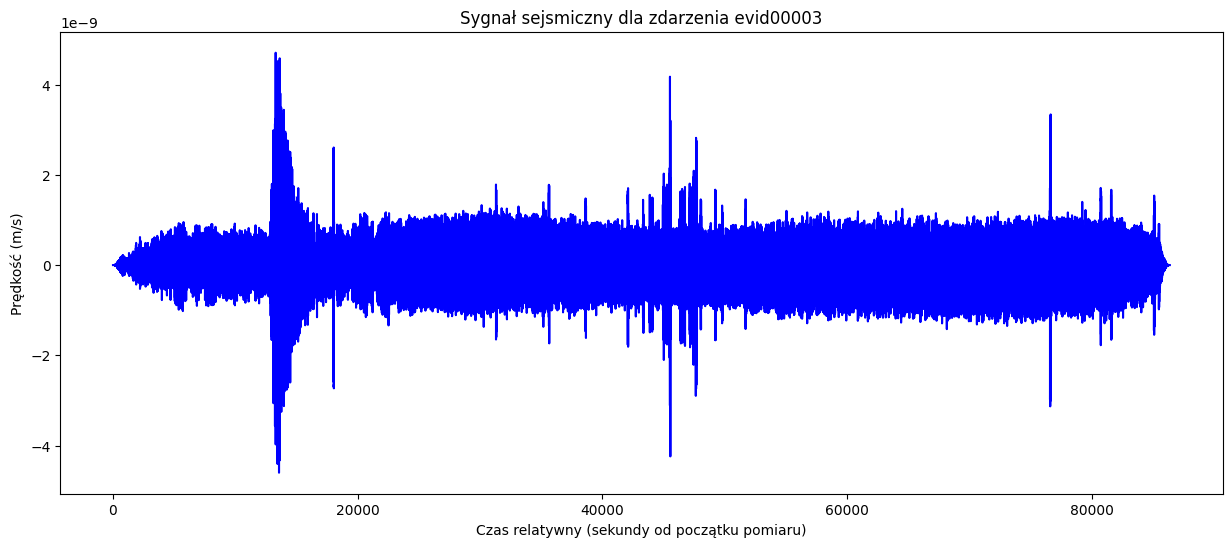

In [23]:
# Używamy czasu relatywnego jako osi X
plt.figure(figsize=(15, 6))
plt.plot(seismic_data['time_rel(sec)'], seismic_data['velocity(m/s)'], color='blue')
plt.title(f'Sygnał sejsmiczny dla zdarzenia {evid}')
plt.xlabel('Czas relatywny (sekundy od początku pomiaru)')
plt.ylabel('Prędkość (m/s)')
plt.show()


<div class="alert alert-block alert-info"> <b>NOTE:</b> Wykres przedstawia sygnał sejsmiczny w funkcji czasu. Możemy zaobserwować zmiany prędkości drgań w czasie. </div>

## Przybliżenie momentu trzęsienia
Dodamy linię pionową wskazującą moment wystąpienia trzęsienia.

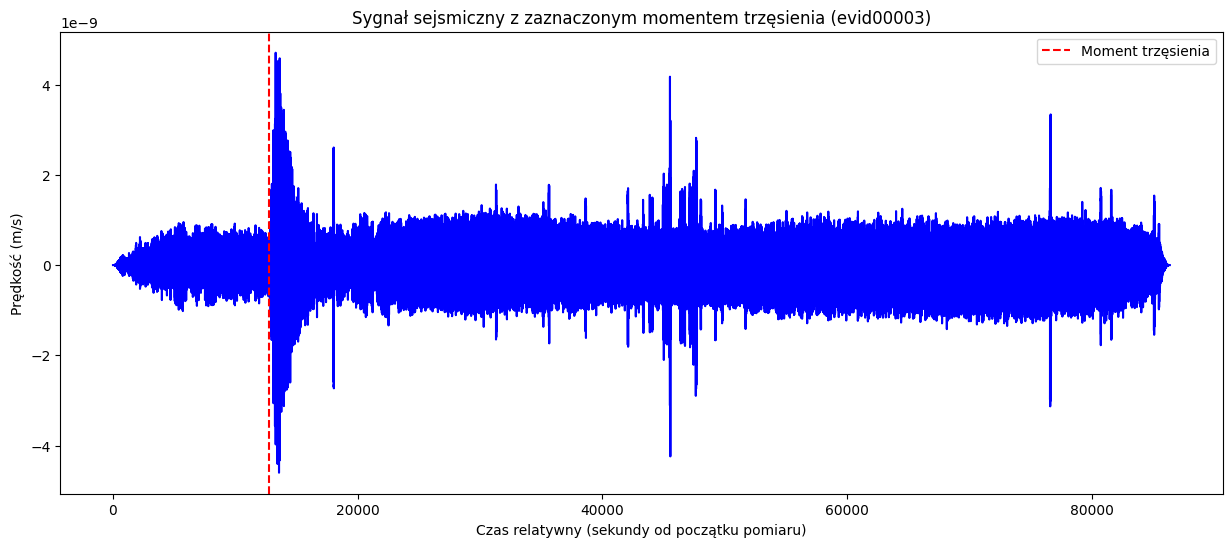

In [24]:
# Moment trzęsienia
quake_time = quake_time_rel  # W sekundach od początku pomiaru

plt.figure(figsize=(15, 6))
plt.plot(seismic_data['time_rel(sec)'], seismic_data['velocity(m/s)'], color='blue')
plt.axvline(x=quake_time, color='red', linestyle='--', label='Moment trzęsienia')
plt.title(f'Sygnał sejsmiczny z zaznaczonym momentem trzęsienia ({evid})')
plt.xlabel('Czas relatywny (sekundy od początku pomiaru)')
plt.ylabel('Prędkość (m/s)')
plt.legend()
plt.show()


<div class="alert alert-block alert-info"> <b>NOTE:</b> Czerwona linia pionowa wskazuje moment wystąpienia trzęsienia w czasie relatywnym. Analizując sygnał przed i po tym momencie, możemy poszukiwać wzorców poprzedzających trzęsienie. </div>

# Analiza statystyczna sygnału
Histogram wartości prędkości

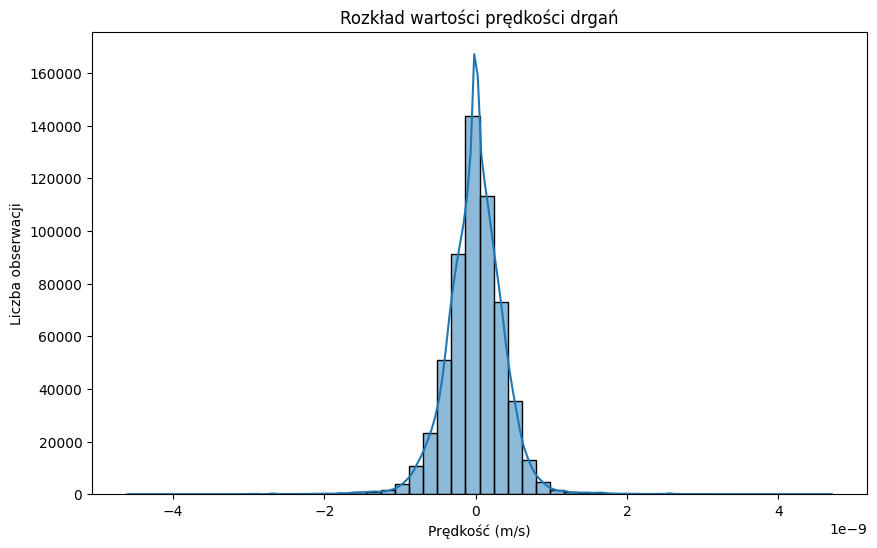

In [25]:
plt.figure(figsize=(10, 6))
sns.histplot(seismic_data['velocity(m/s)'], bins=50, kde=True)
plt.title('Rozkład wartości prędkości drgań')
plt.xlabel('Prędkość (m/s)')
plt.ylabel('Liczba obserwacji')
plt.show()


<div class="alert alert-block alert-info"> <b>NOTE:</b> Rozkład wartości prędkości drgań pokazuje, że większość zarejestrowanych prędkości oscyluje wokół zera, co sugeruje, że wibracje przed i po zdarzeniu są symetryczne i niewielkie. Ekstremalne wartości prędkości występują znacznie rzadziej, co wskazuje na sporadyczne, silniejsze wstrząsy, ale są one znacznie mniej liczne.</div>

## Wykres pudełkowy (boxplot)

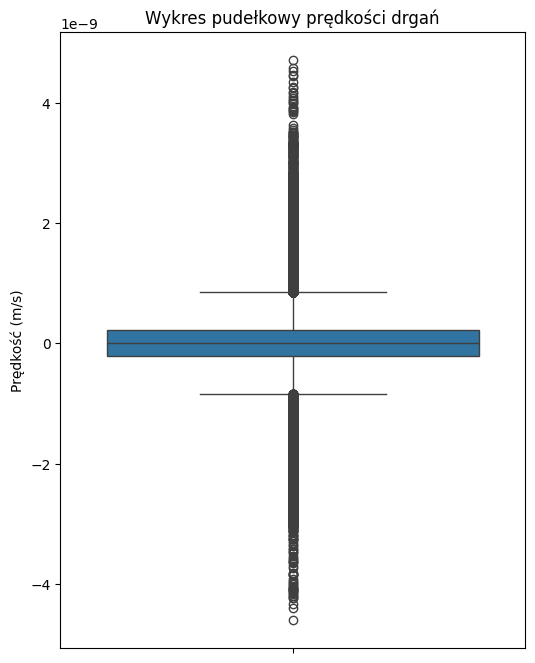

In [30]:
plt.figure(figsize=(6, 8))
sns.boxplot(y=seismic_data['velocity(m/s)'])
plt.title('Wykres pudełkowy prędkości drgań')
plt.ylabel('Prędkość (m/s)')
plt.show()


<div class="alert alert-block alert-info"> <b>NOTE:</b> Wykres pudełkowy pozwala zidentyfikować wartości odstające oraz daje wgląd w kwartyle rozkładu danych. </div>

## Analiza sygnału w dziedzinie częstotliwości

Transformata Fouriera

Przeprowadzimy szybką transformatę Fouriera (FFT), aby zbadać składowe częstotliwościowe sygnału.

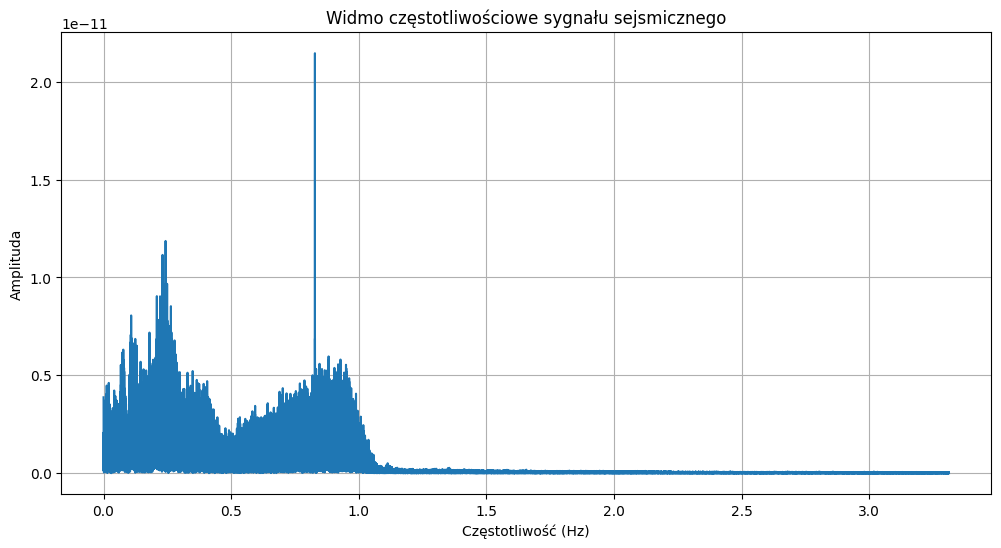

In [41]:
from scipy.fft import fft, fftfreq

y = seismic_data['velocity(m/s)'].values
N = len(y)

time_rel = seismic_data['time_rel(sec)'].values
T = np.mean(np.diff(time_rel))  # Średni czas między próbkami
sampling_rate = 1 / T
yf = fft(y)
xf = fftfreq(N, T)[:N//2]

# Wykres
plt.figure(figsize=(12, 6))
plt.plot(xf, 2.0/N * np.abs(yf[0:N//2]))
plt.title('Widmo częstotliwościowe sygnału sejsmicznego')
plt.xlabel('Częstotliwość (Hz)')
plt.ylabel('Amplituda')
plt.grid()
plt.show()


<div class="alert alert-block alert-info"> <b>NOTE:</b> Widmo częstotliwościowe pozwala zidentyfikować dominujące częstotliwości w sygnale. Sygnał sejsmiczny zawiera wyraźnie zdefiniowane składowe częstotliwościowe. Znaczący pik występuje w okolicach 0,9 Hz, co oznacza, że dominująca częstotliwość sygnału leży w tym zakresie. Warto również zauważyć, że sygnał zawiera wiele niższych składowych częstotliwości, co sugeruje obecność wolniejszych drgań o mniejszej amplitudzie, a wyższe częstotliwości mają znikomy wpływ na ogólną energię sygnału.</div>

## Porównanie sygnału przed i po trzęsieniu

Wykres sygnału w określonym przedziale czasowym

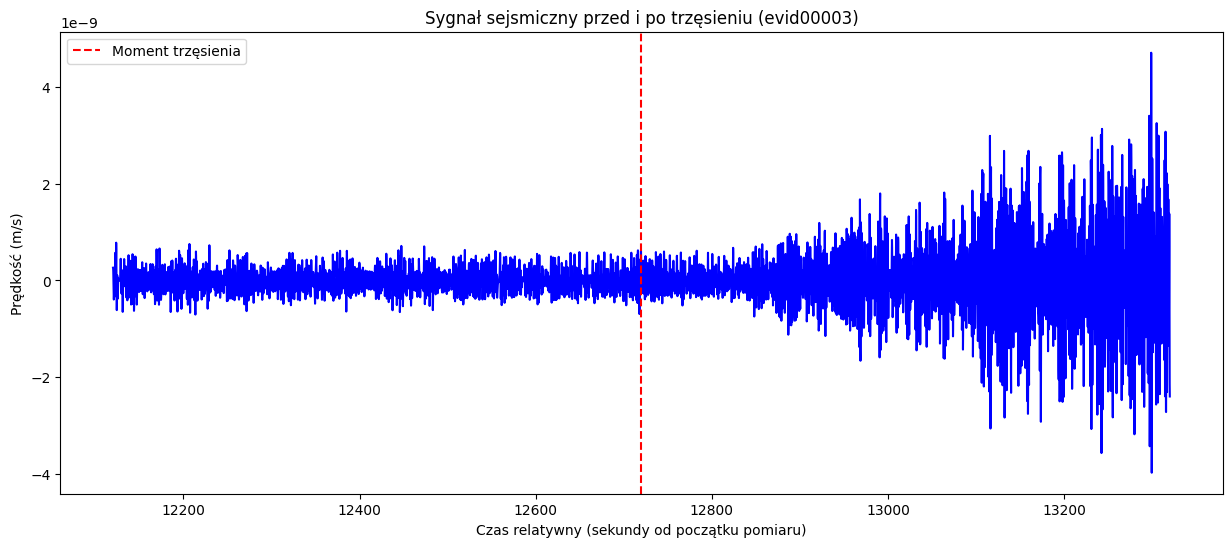

In [34]:
# Okres przed i po trzęsieniu (np. 600 sekund)
pre_quake_duration = 600  # w sekundach
post_quake_duration = 600  # w sekundach
start_time = quake_time - pre_quake_duration
end_time = quake_time + post_quake_duration

# Filtracja danych
mask = (seismic_data['time_rel(sec)'] >= start_time) & (seismic_data['time_rel(sec)'] <= end_time)
seismic_window = seismic_data.loc[mask]

plt.figure(figsize=(15, 6))
plt.plot(seismic_window['time_rel(sec)'], seismic_window['velocity(m/s)'], color='blue')
plt.axvline(x=quake_time, color='red', linestyle='--', label='Moment trzęsienia')
plt.title(f'Sygnał sejsmiczny przed i po trzęsieniu ({evid})')
plt.xlabel('Czas relatywny (sekundy od początku pomiaru)')
plt.ylabel('Prędkość (m/s)')
plt.legend()
plt.show()


## Analiza wielu zdarzeń
Aby uzyskać szerszy obraz, przeanalizujemy dane z kilku zdarzeń.

In [37]:
def plot_seismic_event(event_row, pre_quake_duration=600, post_quake_duration=600):
    filename = event_row['filename']
    evid = event_row['evid']
    quake_time_rel = event_row['time_rel(sec)']  # Relatywny czas wystąpienia trzęsienia
    
    data_file_path = f"../data/lunar/training/data/S12_GradeA/{filename}.csv"
    seismic_data = pd.read_csv(data_file_path)
    
    # Okno czasowe przed i po trzęsieniu
    start_time = quake_time_rel - pre_quake_duration
    end_time = quake_time_rel + post_quake_duration
    
    # Filtracja danych
    mask = (seismic_data['time_rel(sec)'] >= start_time) & (seismic_data['time_rel(sec)'] <= end_time)
    seismic_window = seismic_data.loc[mask]
    
    plt.figure(figsize=(15, 6))
    plt.plot(seismic_window['time_rel(sec)'], seismic_window['velocity(m/s)'], color='blue')
    plt.axvline(x=quake_time_rel, color='red', linestyle='--', label='Moment trzęsienia')
    plt.title(f'Sygnał sejsmiczny przed i po trzęsieniu ({evid})')
    plt.xlabel('Czas relatywny (sekundy od początku pomiaru)')
    plt.ylabel('Prędkość (m/s)')
    plt.legend()
    plt.show()


Analiza zdarzenia: evid00002


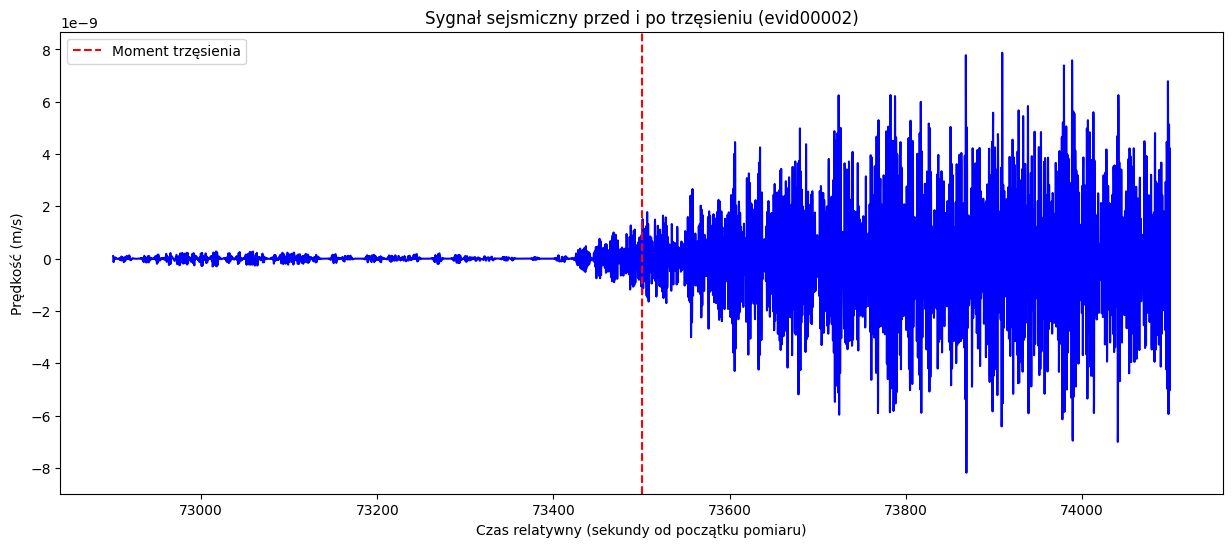

Analiza zdarzenia: evid00003


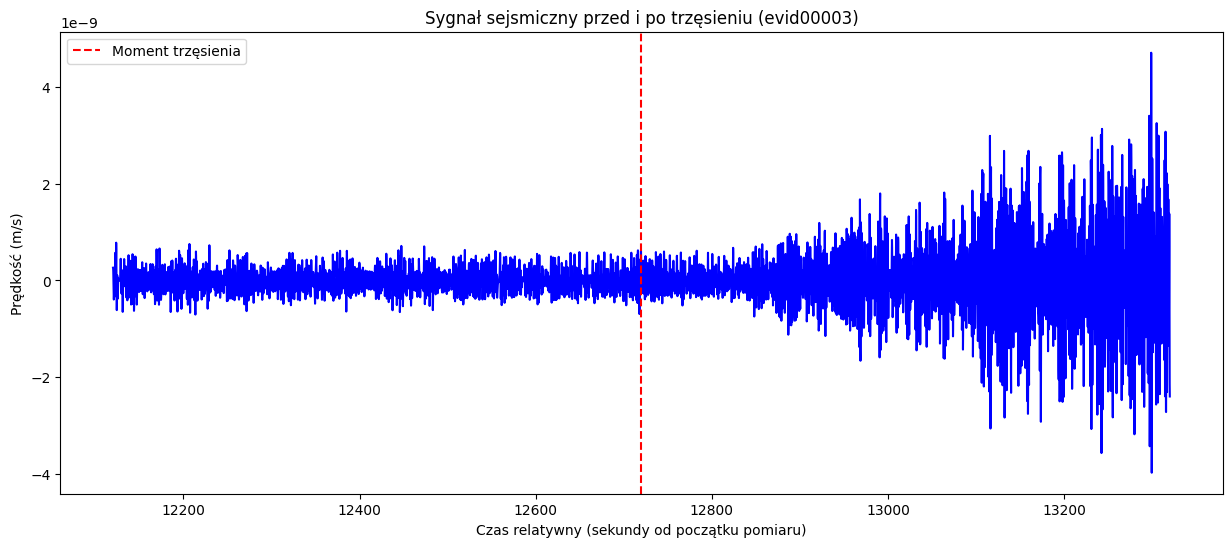

Analiza zdarzenia: evid00004


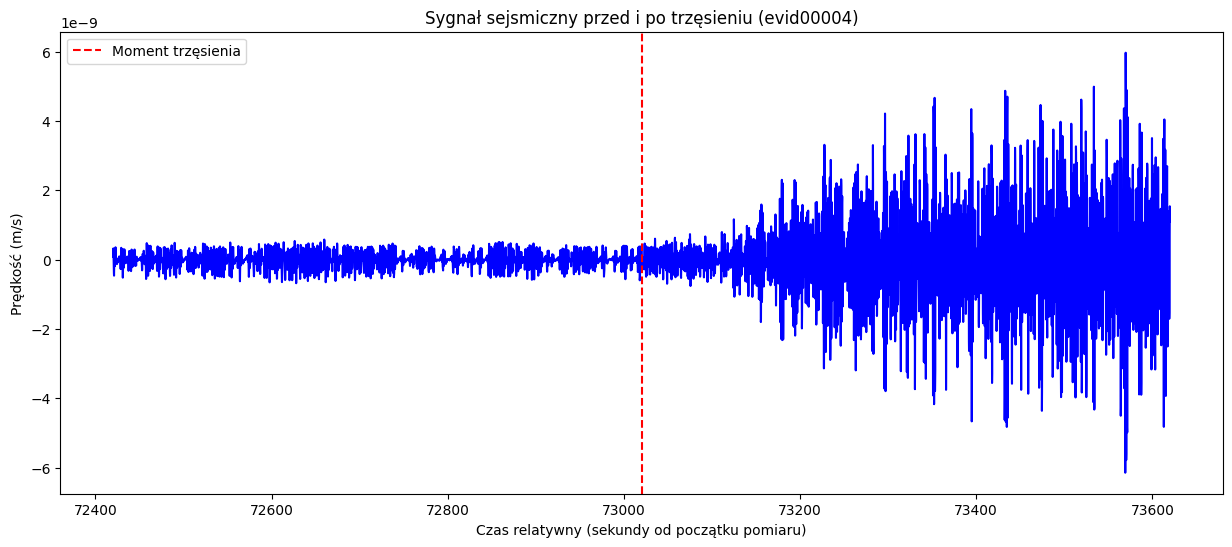

In [40]:
# Wybierzmy pierwsze 3 zdarzenia
for idx in range(3):
    event = catalog.iloc[idx]
    print(f"Analiza zdarzenia: {event['evid']}")
    plot_seismic_event(event)


### Interpretacja sygnałów sejsmicznych z Księżyca

#### 1. **Sygnał przed zdarzeniem**
   - Okres niskiej aktywności sejsmicznej, gdzie prędkości oscylacji są bliskie zeru.
   - Brak wyraźnych drgań, co sugeruje stabilność skorupy księżycowej przed zjawiskiem.

#### 2. **Moment zdarzenia**
   - Zaznaczony czerwoną linią pionową. To punkt, w którym następuje nagły wzrost aktywności sejsmicznej.
   - Fale sejsmiczne zaczynają gwałtownie wzrastać, oznaczając początek silniejszego zdarzenia na Księżycu.

#### 3. **Sygnał po zdarzeniu**
   - Znaczący wzrost amplitudy oscylacji, co świadczy o rozchodzeniu się fal sejsmicznych po powierzchni Księżyca.
   - W miarę upływu czasu sygnał stopniowo maleje, co jest wynikiem rozpraszania energii po zdarzeniu.

### Kluczowe wnioski
- Przed zdarzeniem: cisza sejsmiczna.
- W momencie zdarzenia: gwałtowny wzrost aktywności.
- Po zdarzeniu: rozprzestrzenianie i wygasanie fal sejsmicznych.
